<function matplotlib.pyplot.show(close=None, block=None)>

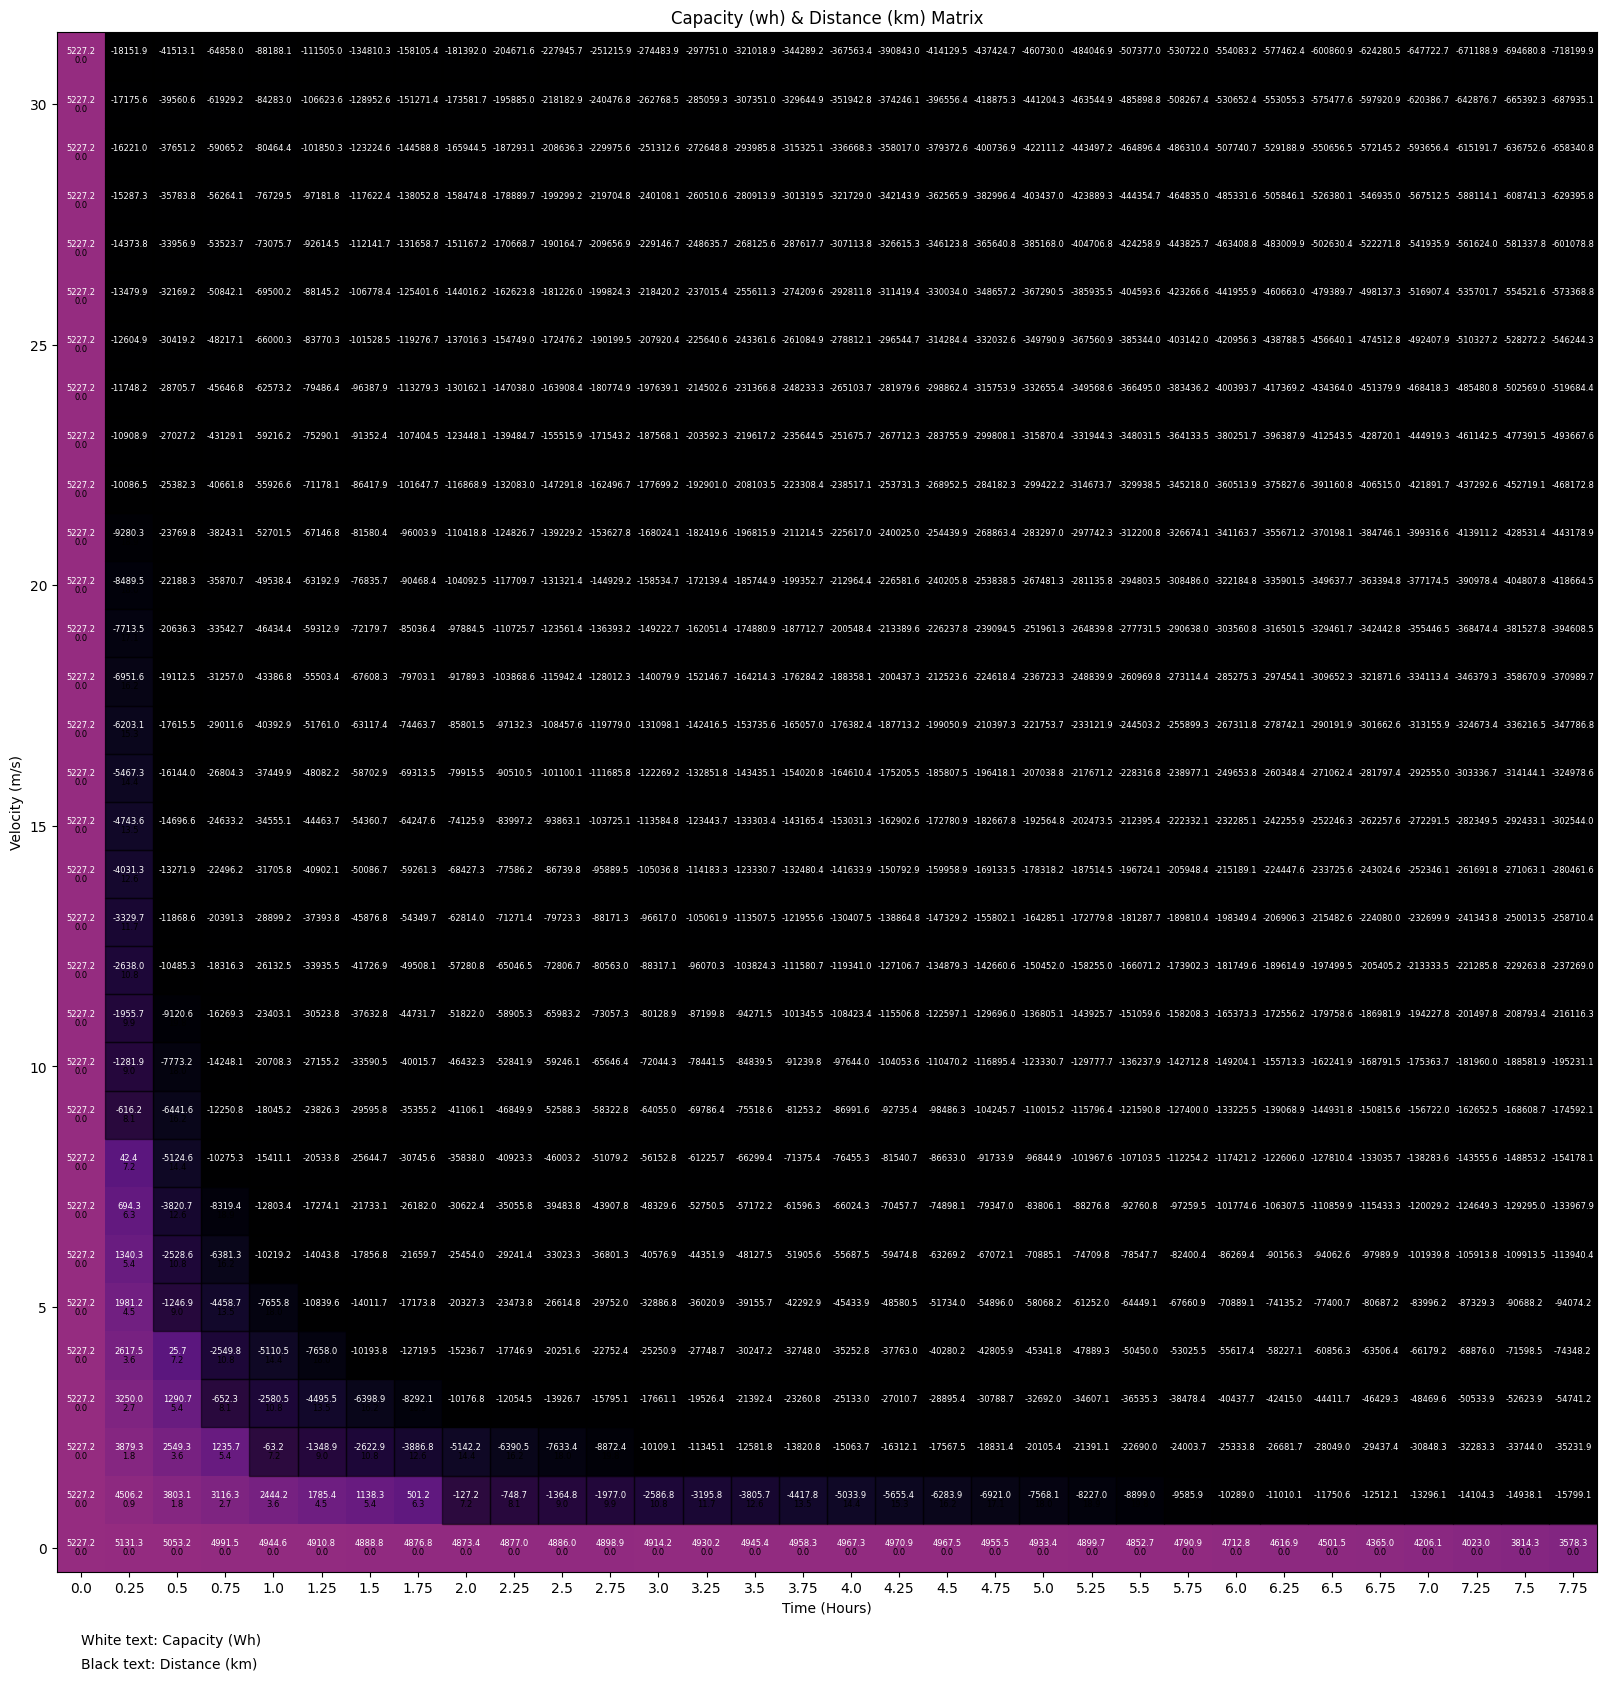

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Properties
m = 300  # mass (kg)
g = 9.81  # acceleration due to gravity (m/s^2)
C_r1 = 0.004  # rolling resistance coefficient 1
C_r2 = 0.052  # rolling resistance coefficient 2
C_d = 0.13  # drag coefficient
A_drag = 1.357  # cross-sectional area (m^2)
p = 1.293  # air density (kg/m^3)
n = 0.16  # efficiency of solar panel
A_solar = 4  # area of solar panel (m^2)
bat_capacity = 40*3.63*36 # pack capacity (Wh)

# Power (Out)
def rolling_resistance(v):
    return (m * g * C_r1 + 4 * C_r2 * v) * v

def drag_resistance(v):
    return 0.5 * p * C_d * A_drag * v ** 3

def gradient_resistance(v):
    theta = 12 # need to replace with real route data
    return m * g * np.sin(np.deg2rad(theta)) * v

# Power (In)
def solar_power(t):
    G = -1.5e-6 * (t - 10800)**2 + 1000 # arbitrary solar profile, need to replace w/ live forecasting
    return A_solar * G * n

velocities = np.arange(1, 33)
times = np.arange(1, 28800, 900)
output = np.zeros((32,32))
solar_power_values = np.zeros((32,32))
rolling_resistance_values = np.zeros((32,32))
drag_resistance_values = np.zeros((32,32))
gradient_resistance_values = np.zeros((32,32))
capacity_values = np.full((32,32), bat_capacity)
i = 0
j = 0
t = 0

for i, v in enumerate(velocities):
    for j, t in enumerate(times):
        solar_power_values[i, j] = solar_power(t)
        rolling_resistance_values[i, j] = rolling_resistance(v)
        drag_resistance_values[i, j] = drag_resistance(v)
        gradient_resistance_values[i, j] = gradient_resistance(v)

energy_consumed = - solar_power_values + rolling_resistance_values + drag_resistance_values + gradient_resistance_values # watt-hours

for j in range(1, 32):
    capacity_values[:, j] = capacity_values[:, j-1] - energy_consumed[:, j-1]

plt.figure(figsize=(20, 20))  # Width and height in inches
plt.title('Capacity (wh) & Distance (km) Matrix')
plt.xlabel('Time (Hours)')
plt.ylabel('Velocity (m/s)')
plt.imshow(capacity_values, cmap='magma', vmin=-10000, vmax=26000)
ax = plt.gca()
for (i, j), val in np.ndenumerate(capacity_values):
    if val < 0:
        rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, color='black', alpha=0.5)
        ax.add_patch(rect)
    plt.text(j, i, f'{val:.1f}', ha='center', va='bottom', color='white', fontsize='6')
    plt.text(j, i, f'{i * j * 0.9:.1f}', ha='center', va='top', color='black', fontsize='6')  # Product value
plt.xticks(ticks=np.arange(0, capacity_values.shape[1]), labels=[f'{i/4}' for i in range(capacity_values.shape[1])])
plt.text(0, -2.5, 'Black text: Distance (km)', color='black', fontsize='10')
plt.text(0, -2, 'White text: Capacity (Wh)', color='black', fontsize='10')
plt.gca().invert_yaxis()
plt.show

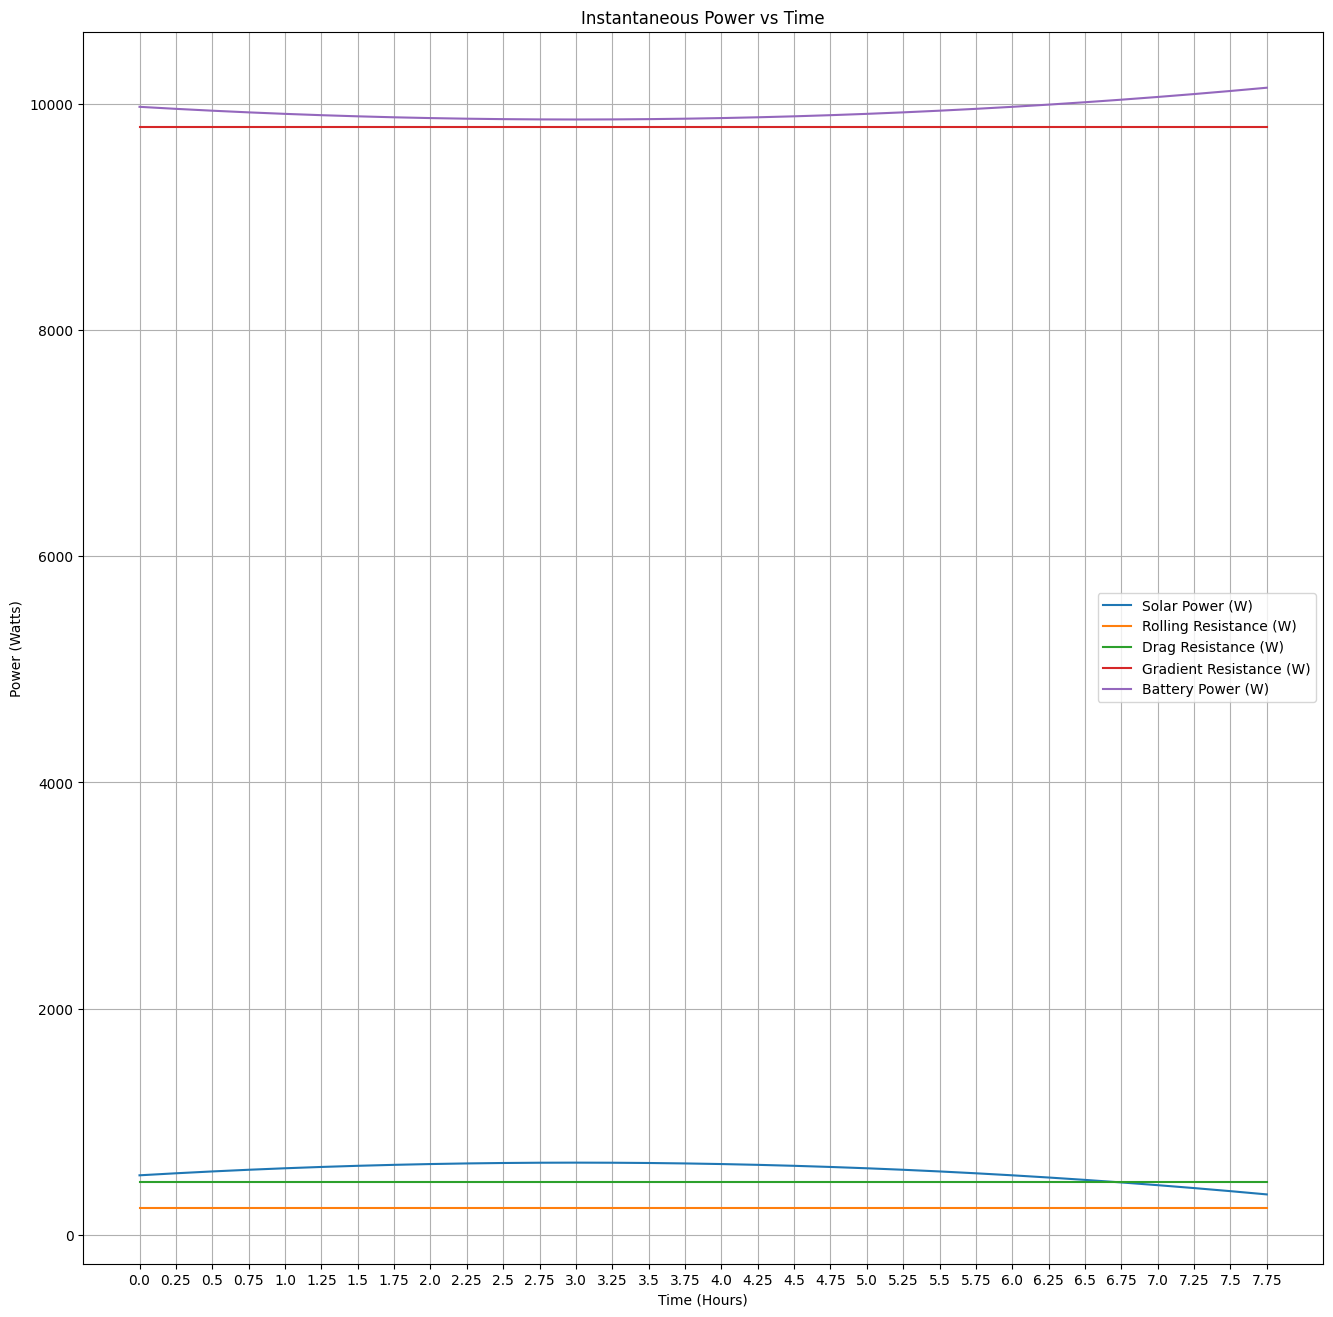

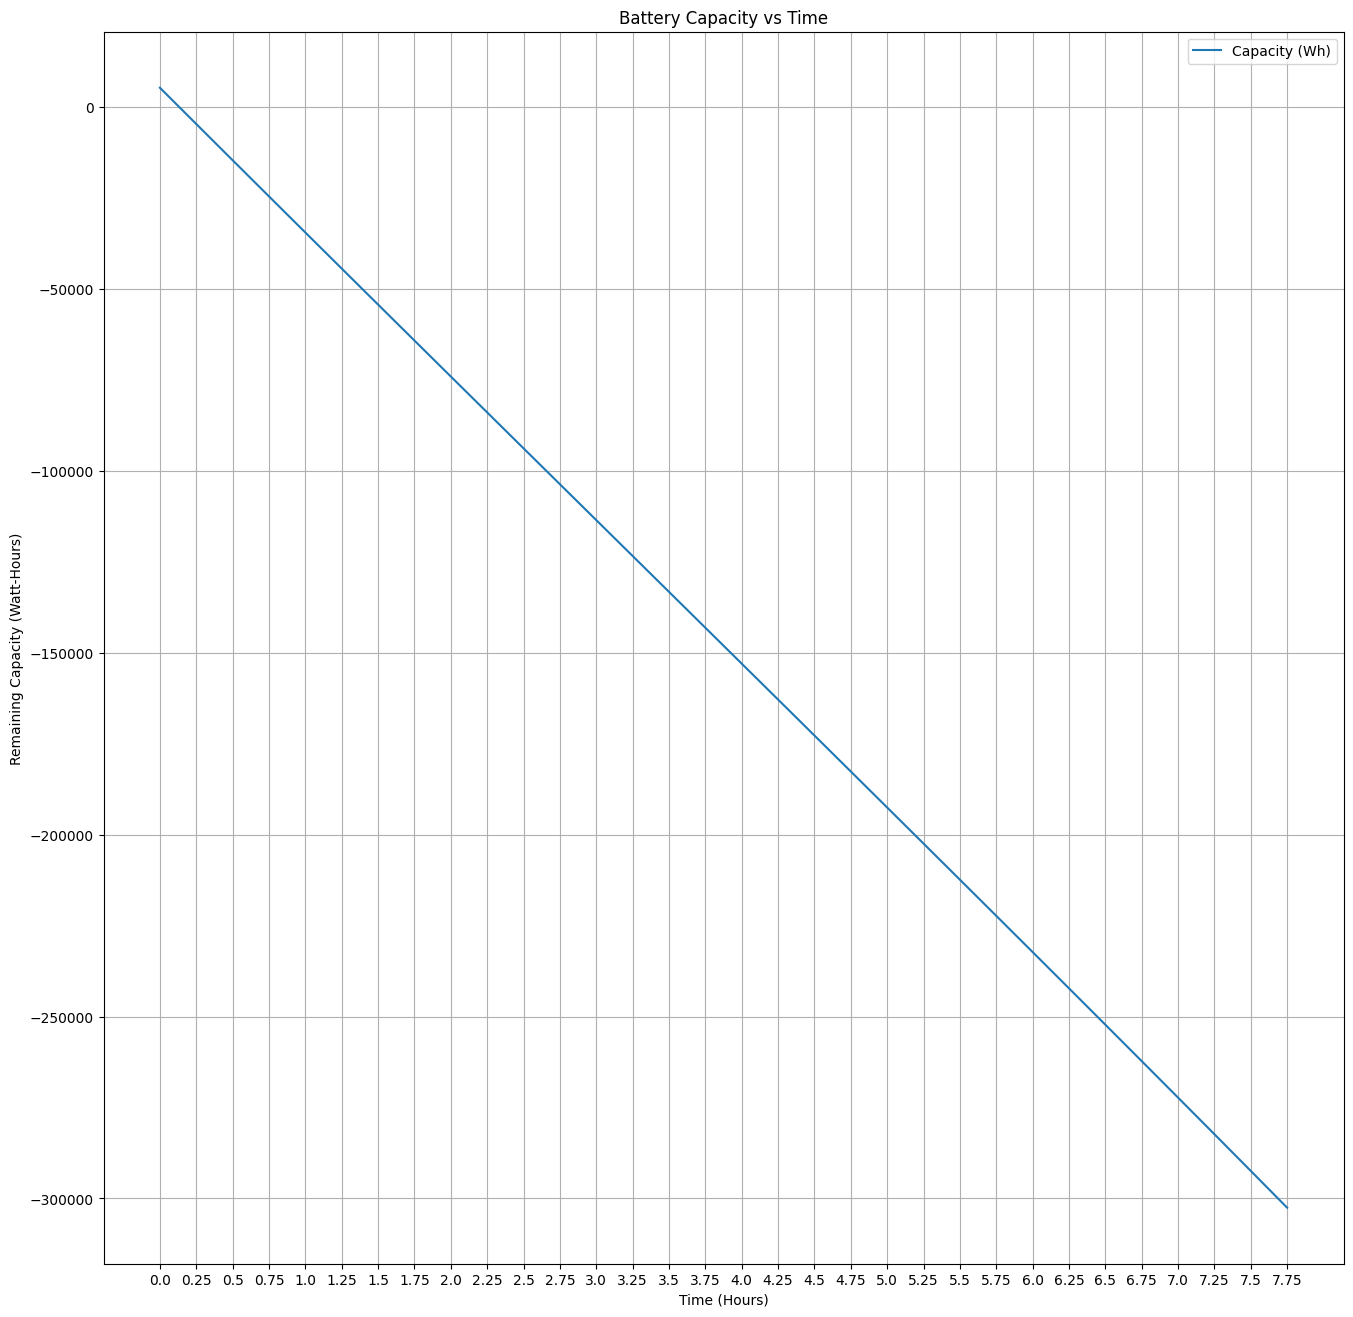

In [11]:
# Velocity Specific Plots
v = 15

plt.figure(figsize=(16, 16))
plt.plot(solar_power_values[v, :], label='Solar Power (W)')
plt.plot(rolling_resistance_values[v, :], label='Rolling Resistance (W)')
plt.plot(drag_resistance_values[v, :], label='Drag Resistance (W)')
plt.plot(gradient_resistance_values[v, :], label='Gradient Resistance (W)')
plt.plot(energy_consumed[v, :], label='Battery Power (W)')
plt.xlabel('Time (Hours)')
plt.ylabel('Power (Watts)')
plt.title('Instantaneous Power vs Time')
plt.xticks(ticks=np.arange(0, capacity_values.shape[1]), labels=[f'{i/4}' for i in range(capacity_values.shape[1])])
plt.legend()
plt.grid(True)

plt.figure(figsize=(16, 16))
plt.plot(capacity_values[v, :], label='Capacity (Wh)')
plt.xlabel('Time (Hours)')
plt.ylabel('Remaining Capacity (Watt-Hours)')
plt.title('Battery Capacity vs Time')
plt.xticks(ticks=np.arange(0, capacity_values.shape[1]), labels=[f'{i/4}' for i in range(capacity_values.shape[1])])
plt.legend()
plt.grid(True)

In [ ]:
import psycopg2
import os
from dotenv import load_dotenv 

load_dotenv() 
# print(os.getenv("DB_NAME"))
# print(os.getenv("DB_USER"))
# print(os.getenv("HOST"))
# print(os.getenv("DB_PASSWORD"))
# print(os.getenv("IRRADIANCE_API"))

def connect_to_db():
    db_user, db_password, db_host, db_name = (
        os.getenv("DB_USER"),
        os.getenv("DB_PASSWORD"),
        os.getenv("HOST"),
        os.getenv("DB_NAME"),
    )
    return psycopg2.connect(
        host=db_host, database=db_name, user=db_user, password=db_password
    )

def fetch_data(query):
    connection = connect_to_db()
    cursor = connection.cursor()
    cursor.execute(query)
    results = cursor.fetchall()
    cursor.close()
    connection.close()
    return results

def insert_data(query):
    connection = connect_to_db()
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        connection.commit()
        print("Data inserted successfully")
    except Exception as e:
        print("An error occurred:", e)
        connection.rollback()
    finally:
        cursor.close()
        connection.close()

def list_tables():
    query = "SELECT tablename FROM pg_tables WHERE schemaname='public';"
    return fetch_data(query)

def create_table(query):
    connection = connect_to_db()
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        connection.commit()
        print("Table created successfully")
    except Exception as e:
        print("Error occurred:", e)
        connection.rollback()
    finally:
        cursor.close()
        connection.close()


In [ ]:
map_distance_to_irradiance("A", 100, 5699)['ghi'].values[0]

In [ ]:
query = "SELECT * FROM base_route ORDER BY id LIMIT 1"
results = fetch_data(query)
print(results)

In [ ]:
tables = list_tables()
print("Available tables:", tables)

In [ ]:
import requests

def fetch_irradiance_data(lat, lon, format="csv"):

    key = os.getenv("IRRADIANCE_API")

    url = f"https://api.solcast.com.au/data/forecast/radiation_and_weather?latitude={lat}&longitude={lon}&format={format}&api_key={key}"
    response = requests.get(url)
    return response.content


data = fetch_irradiance_data("-33.86882", "151.209295")
print(data)

In [ ]:
import pandas as pd
from io import StringIO

decoded_data = data.decode('utf-8')

decoded_cata = StringIO(decoded_data)

df = pd.read_csv(decoded_cata)

df


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from db_funcs import connect_to_db, map_distance_to_id, map_distance_to_irradiance
import math

# Properties
m = 300  # mass (kg)
g = 9.81  # acceleration due to gravity (m/s^2)
C_r1 = 0.004  # rolling resistance coefficient 1
C_r2 = 0.052  # rolling resistance coefficient 2
C_d = 0.13  # drag coefficient
A_drag = 1.357  # cross-sectional area (m^2)
p = 1.293  # air density (kg/m^3)
n = 0.16  # efficiency of solar panel
A_solar = 4  # area of solar panel (m^2)
bat_capacity = 40*3.63*36 # pack capacity (Wh)

# Power (Out)
def rolling_resistance(v):
    return (m * g * C_r1 + 4 * C_r2 * v) * v

def drag_resistance(v):
    return 0.5 * p * C_d * A_drag * v ** 3

def gradient_resistance(v, theta):
    return m * g * np.sin(np.deg2rad(theta)) * v

# Power (In)
def solar_power(G):
    # G = -1.5e-6 * (t - 10800)**2 + 1000 # arbitrary solar profile, need to replace w/ live forecasting
    return A_solar * G * n

velocities = np.arange(1, 33)
times = np.arange(1, 28800, 900)
output = np.zeros((32,32))
solar_power_values = np.zeros((32,32))
rolling_resistance_values = np.zeros((32,32))
drag_resistance_values = np.zeros((32,32))
gradient_resistance_values = np.zeros((32,32))
capacity_values = np.full((32,32), bat_capacity)
i = 0
j = 0
t = 0

connection = connect_to_db()

for i, v in enumerate(velocities):
    for j, t in enumerate(times):
        try: 
            d = v*t
            row_df = map_distance_to_id(connection, '1A', d)['elevation'].values[0]
            row_df2 = map_distance_to_id(connection, '1A', d*2)['elevation'].values[0]
            v_wind = map_distance_to_irradiance(connection, "1A", d, t)['wind_speed_10m'].values[0]*np.cos(np.deg2rad(map_distance_to_id(connection, '1A', d)['car_bearing'].values[0] - map_distance_to_irradiance(connection, "1A", d, t)['wind_direction_10m'].values[0]))
        except:
            continue
        v_adj = 0
        theta = math.degrees(math.atan((row_df2-row_df)/d))
        irradiance = map_distance_to_irradiance(connection, "1A", d, t)['ghi'].values[0]
        # print(f"i:{i}, j:{j}")
        # print(d)
        # print(f"final elevation:{row_df2}, initial elevation:{row_df}")
        # print(f"theta: {theta}")
        # theta = row_df["elevation_weight"].values[0]
        # print(f"irradiance: {irradiance}")
        v_adj = v_wind+v
        solar_power_values[i, j] = solar_power(irradiance)
        rolling_resistance_values[i, j] = rolling_resistance(v)
        drag_resistance_values[i, j] = drag_resistance(v_adj)
        gradient_resistance_values[i, j] = gradient_resistance(v, theta)

connection.close()        

energy_consumed = - solar_power_values + rolling_resistance_values + drag_resistance_values + gradient_resistance_values # watt-hours

for j in range(1, 32):
    capacity_values[:, j] = capacity_values[:, j-1] - energy_consumed[:, j-1]